# Predict Bike Sharing Demand with AutoGluon Template

## Project: Predict Bike Sharing Demand with AutoGluon
This notebook is a template with each step that you need to complete for the project.

Please fill in your code where there are explicit `?` markers in the notebook. You are welcome to add more cells and code as you see fit.

Once you have completed all the code implementations, please export your notebook as a HTML file so the reviews can view your code. Make sure you have all outputs correctly outputted.

`File-> Export Notebook As... -> Export Notebook as HTML`

There is a writeup to complete as well after all code implememtation is done. Please answer all questions and attach the necessary tables and charts. You can complete the writeup in either markdown or PDF.

Completing the code template and writeup template will cover all of the rubric points for this project.

The rubric contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this notebook and also discuss the results in the writeup file.

## Step 1: Create an account with Kaggle

### Create Kaggle Account and download API key
Below is example of steps to get the API username and key. Each student will have their own username and key.

1. Open account settings.

2. Scroll down to API and click Create New API Token.

3. Open up `kaggle.json` and use the username and key.


## Step 2: Download the Kaggle dataset using the kaggle python library

### Open up Sagemaker Studio and use starter template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

In [1]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 9.9 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 55.1 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/p

### Setup Kaggle API Key

In [4]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "FILL_IN_USERNAME"
kaggle_key = "FILL_IN_KEY"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

### Go to the bike sharing demand competition and agree to the terms


In [13]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
#!unzip -o bike-sharing-demand.zip

401 - Unauthorized


In [14]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [17]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("/content/train.csv")
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [ ]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

In [18]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("/content/test.csv")
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [19]:
# Same thing as train and test dataset
submission = pd.read_csv("/content/sampleSubmission.csv")
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [20]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [21]:
train.drop(columns = ["casual", "registered"],inplace = True)
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1


In [22]:
predictor = TabularPredictor(label = 'count',eval_metric = "root_mean_squared_error").fit(train_data = train ,  time_limit  = 600 , presets = "best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20220718_183126/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220718_183126/"
AutoGluon Version:  0.5.0
Python Version:     3.7.13
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 9
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    12059.76 MB
	Train Data (Original)  Memory Usage: 1.

### Review AutoGluon's training run with ranking of models that did the best.

In [23]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -52.588686      14.592571  471.715399                0.000719           0.460664            3       True         17
1   RandomForestMSE_BAG_L2  -53.436379      13.368493  412.901057                0.598281          28.396258            2       True         13
2     ExtraTreesMSE_BAG_L2  -53.756692      13.360186  392.340383                0.589974           7.835584            2       True         15
3          LightGBM_BAG_L2  -55.243713      13.017183  404.756034                0.246971          20.251235            2       True         12
4          CatBoost_BAG_L2  -55.738051      12.834581  442.866735                0.064369          58.361936            2       True         14
5   NeuralNetFastAI_BAG_L2  -56.719786      13.156626  414.771658         

{'leaderboard':                      model   score_val  pred_time_val    fit_time  \
 0      WeightedEnsemble_L3  -52.588686      14.592571  471.715399   
 1   RandomForestMSE_BAG_L2  -53.436379      13.368493  412.901057   
 2     ExtraTreesMSE_BAG_L2  -53.756692      13.360186  392.340383   
 3          LightGBM_BAG_L2  -55.243713      13.017183  404.756034   
 4          CatBoost_BAG_L2  -55.738051      12.834581  442.866735   
 5   NeuralNetFastAI_BAG_L2  -56.719786      13.156626  414.771658   
 6        LightGBMXT_BAG_L2  -60.269798      15.670026  430.269125   
 7    KNeighborsDist_BAG_L1  -84.125061       0.103625    0.039399   
 8      WeightedEnsemble_L2  -84.125061       0.104821    0.563049   
 9    KNeighborsUnif_BAG_L1 -101.546199       0.102778    0.029768   
 10  RandomForestMSE_BAG_L1 -116.544294       0.517232   10.038474   
 11    ExtraTreesMSE_BAG_L1 -124.588053       0.501942    4.524314   
 12         CatBoost_BAG_L1 -130.472284       0.121524  183.454202   
 13  

### Create predictions from test dataset

In [24]:
predictions = predictor.predict(test)
predictions.head()

0    23.550512
1    40.808868
2    44.458626
3    47.286266
4    50.420288
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [25]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      101.748779
std        89.129524
min         2.031049
25%        23.832951
50%        67.130913
75%       170.800186
max       359.129395
Name: count, dtype: float64

In [26]:
# How many negative values do we have?
print(len(predictions))
(predictions[predictions < 0] )

6493


Series([], Name: count, dtype: float32)

In [27]:
# Set them to zero
predictions[predictions < 0 ] = 0
predictions.head()

0    23.550512
1    40.808868
2    44.458626
3    47.286266
4    50.420288
Name: count, dtype: float32

### Set predictions to submission dataframe, save, and submit

In [28]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [29]:
#!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [30]:
#!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

#### Initial score of `?`

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe9993f7810>,
      dtype=object)

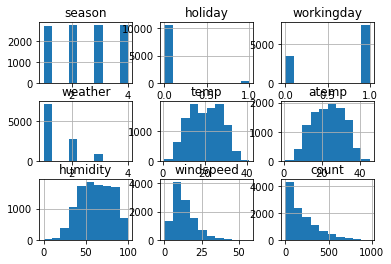

In [31]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist()

In [32]:
train["datetime"] = pd.to_datetime(train["datetime"])
test["datetime"] = pd.to_datetime(test["datetime"])

In [33]:
# create a new feature
train['second'] =  train.datetime.dt.second
train['minute'] =  train.datetime.dt.minute
train['hour'] =  train.datetime.dt.hour
train['day'] =  train.datetime.dt.day
train['month'] =  train.datetime.dt.month

train['year'] =  train.datetime.dt.year

#test[?] = ?

In [34]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,second,minute,hour,day,month,year
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,0,0,0,1,1,2011
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,0,0,1,1,1,2011
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,0,0,2,1,1,2011
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,0,0,3,1,1,2011
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,0,0,4,1,1,2011


In [35]:
test['second'] =  test.datetime.dt.second
test['minute'] =  test.datetime.dt.minute
test['hour'] =  test.datetime.dt.hour
test['day'] =  test.datetime.dt.day
test['month'] =  test.datetime.dt.month
test['year'] =  test.datetime.dt.year

In [36]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,second,minute,hour,day,month,year
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,0,0,0,20,1,2011
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,0,0,1,20,1,2011
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,0,0,2,20,1,2011
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,0,0,3,20,1,2011
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,0,0,4,20,1,2011


## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [37]:
train["season"] = train["season"].astype("category") 
train["weather"] = train["weather"].astype("category") 
test["season"] = test["season"].astype("category") 
test["weather"] = test["weather"].astype("category")

In [38]:
# View are new feature
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,second,minute,hour,day,month,year
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,0,0,0,1,1,2011
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,0,0,1,1,1,2011
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,0,0,2,1,1,2011
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,0,0,3,1,1,2011
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,0,0,4,1,1,2011


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe999573290>,
      dtype=object)

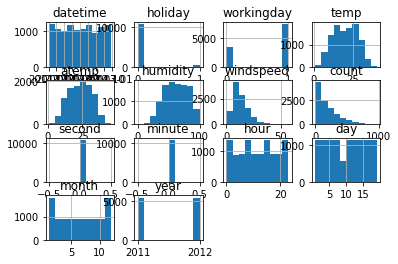

In [39]:
# View histogram of all features again now with the hour feature
train.hist()

## Step 5: Rerun the model with the same settings as before, just with more features

In [40]:
predictor_new_features = predictor_new_hpo = TabularPredictor(label = "count" ,eval_metric = "root_mean_squared_error" ).fit(time_limit = 600 , presets = "best_quality" , train_data = train)

No path specified. Models will be saved in: "AutogluonModels/ag-20220718_184209/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220718_184209/"
AutoGluon Version:  0.5.0
Python Version:     3.7.13
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 15
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11659.95 MB
	Train Data (Original)  Memory Usage: 1

In [41]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -30.214835      13.966882  560.471848                0.000734           0.307906            3       True         15
1          CatBoost_BAG_L2  -30.409463      12.059606  481.910322                0.144569          88.333001            2       True         13
2          LightGBM_BAG_L2  -30.722643      12.165332  414.238742                0.250295          20.661421            2       True         11
3        LightGBMXT_BAG_L2  -31.224679      12.952870  419.768789                1.037833          26.191467            2       True         10
4     ExtraTreesMSE_BAG_L2  -31.437290      12.543442  402.613799                0.628405           9.036478            2       True         14
5   RandomForestMSE_BAG_L2  -31.609205      12.533451  424.978053         

{'leaderboard':                      model   score_val  pred_time_val    fit_time  \
 0      WeightedEnsemble_L3  -30.214835      13.966882  560.471848   
 1          CatBoost_BAG_L2  -30.409463      12.059606  481.910322   
 2          LightGBM_BAG_L2  -30.722643      12.165332  414.238742   
 3        LightGBMXT_BAG_L2  -31.224679      12.952870  419.768789   
 4     ExtraTreesMSE_BAG_L2  -31.437290      12.543442  402.613799   
 5   RandomForestMSE_BAG_L2  -31.609205      12.533451  424.978053   
 6      WeightedEnsemble_L2  -32.086164      10.884509  347.128956   
 7          CatBoost_BAG_L1  -33.697982       0.267037  219.782176   
 8          LightGBM_BAG_L1  -33.917338       2.526168   38.163175   
 9        LightGBMXT_BAG_L1  -34.305322       7.404306   75.284508   
 10    ExtraTreesMSE_BAG_L1  -38.343705       0.557975    6.029046   
 11  RandomForestMSE_BAG_L1  -38.442020       0.582637   13.246457   
 12  NeuralNetFastAI_BAG_L1  -65.062265       0.369486   40.991025   
 13  

In [42]:
predictor2 =  predictor_new_features.predict(test)

In [43]:
predictor2.head()

0    16.686827
1    11.861774
2    11.025127
3     9.817257
4     8.336437
Name: count, dtype: float32

In [44]:
# Remember to set all negative values to zero
predictor2[predictor2<0]

Series([], Name: count, dtype: float32)

In [45]:
predictor2[predictor2<0] = 0

In [46]:
predictor2.head()

0    16.686827
1    11.861774
2    11.025127
3     9.817257
4     8.336437
Name: count, dtype: float32

In [47]:
sumbission_new_features =  pd.read_csv("/content/sampleSubmission.csv")

In [48]:
sumbission_new_features.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [49]:
sumbission_new_features["datetime"] = pd.to_datetime(sumbission_new_features["datetime"])

In [50]:
# Same submitting predictions
sumbission_new_features["count"] = predictor2
sumbission_new_features.to_csv("submission_new_features.csv", index=False)

In [51]:
#!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

In [52]:
#!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

#### New Score of `?`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [53]:
import autogluon.core as ag

num_trials  = 10 
search_strategy = 'auto'
nn_options = {  
    'num_epochs': 50,
    'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),  
    'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'), 
    'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1),
}

gbm_options = {  
    'num_boost_round': 100, 
    'num_leaves': ag.space.Int(lower=26, upper=66, default=36),  
}

hyperparameters = {  
                   'GBM': gbm_options,
                   'NN_TORCH': nn_options,  
}
hyperparameter_tune_kwargs = { 
    'num_trials': num_trials,
    'scheduler' : 'local',
    'searcher': search_strategy,
}

In [54]:
predictor_new_hpo = TabularPredictor(label = "count" ,eval_metric = "root_mean_squared_error" ).fit(time_limit = 600 , presets = "best_quality" ,  hyperparameters=hyperparameters, hyperparameter_tune_kwargs=hyperparameter_tune_kwargs, train_data = train)

No path specified. Models will be saved in: "AutogluonModels/ag-20220718_185251/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220718_185251/"
AutoGluon Version:  0.5.0
Python Version:     3.7.13
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 15
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11929.25 MB
	Train Data (Original)  Memory Usage: 1

  0%|          | 0/10 [00:00<?, ?it/s]

Fitted model: LightGBM_BAG_L1/T1 ...
	-39.5016	 = Validation score   (-root_mean_squared_error)
	0.34s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM_BAG_L1/T2 ...
	-37.3144	 = Validation score   (-root_mean_squared_error)
	0.3s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM_BAG_L1/T3 ...
	-36.7779	 = Validation score   (-root_mean_squared_error)
	0.37s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM_BAG_L1/T4 ...
	-120.7115	 = Validation score   (-root_mean_squared_error)
	0.31s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM_BAG_L1/T5 ...
	-41.8284	 = Validation score   (-root_mean_squared_error)
	0.34s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM_BAG_L1/T6 ...
	-109.1997	 = Validation score   (-root_mean_squared_error)
	0.36s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM_BAG_L1/T7 ...
	-36.744	 = Validation score   (-root_

  0%|          | 0/10 [00:00<?, ?it/s]

	Stopping HPO to satisfy time limit...
Fitted model: NeuralNetTorch_BAG_L1/T1 ...
	-43.7766	 = Validation score   (-root_mean_squared_error)
	15.72s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: LightGBM_BAG_L1/T1 ... Training model for up to 379.79s of the 579.81s of remaining time.
	Fitting 7 child models (S1F2 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	-40.2554	 = Validation score   (-root_mean_squared_error)
	13.59s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: LightGBM_BAG_L1/T2 ... Training model for up to 360.92s of the 560.94s of remaining time.
	Fitting 7 child models (S1F2 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	-39.0553	 = Validation score   (-root_mean_squared_error)
	13.36s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: LightGBM_BAG_L1/T3 ... Training model for up to 345.41s of the 545.43s of remaining time.
	Fitting 7 child models (S1F2 - S1F8) | Fitting with ParallelLocalFoldFitting

  0%|          | 0/10 [00:00<?, ?it/s]

Fitted model: LightGBM_BAG_L2/T1 ...
	-38.1252	 = Validation score   (-root_mean_squared_error)
	0.64s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM_BAG_L2/T2 ...
	-38.0837	 = Validation score   (-root_mean_squared_error)
	0.43s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM_BAG_L2/T3 ...
	-38.0777	 = Validation score   (-root_mean_squared_error)
	0.58s	 = Training   runtime
	0.03s	 = Validation runtime
Fitted model: LightGBM_BAG_L2/T4 ...
	-101.9393	 = Validation score   (-root_mean_squared_error)
	0.45s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM_BAG_L2/T5 ...
	-38.368	 = Validation score   (-root_mean_squared_error)
	0.52s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM_BAG_L2/T6 ...
	-98.9992	 = Validation score   (-root_mean_squared_error)
	0.56s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM_BAG_L2/T7 ...
	-38.0485	 = Validation score   (-root_

  0%|          | 0/10 [00:00<?, ?it/s]

	Ran out of time, stopping training early. (Stopping on epoch 41)
	Stopping HPO to satisfy time limit...
Fitted model: NeuralNetTorch_BAG_L2/T1 ...
	-38.1669	 = Validation score   (-root_mean_squared_error)
	13.58s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: LightGBM_BAG_L2/T1 ... Training model for up to 286.32s of the 286.3s of remaining time.
	Fitting 7 child models (S1F2 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	-34.4221	 = Validation score   (-root_mean_squared_error)
	14.79s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: LightGBM_BAG_L2/T2 ... Training model for up to 269.79s of the 269.77s of remaining time.
	Fitting 7 child models (S1F2 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	-34.2775	 = Validation score   (-root_mean_squared_error)
	15.72s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: LightGBM_BAG_L2/T3 ... Training model for up to 251.93s of the 251.91s of remaining time.
	Fitting 7 ch

In [55]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                       model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0        WeightedEnsemble_L3  -33.873361       2.642558  426.503501                0.000809           0.365879            3       True         24
1         LightGBM_BAG_L2/T2  -34.277470       1.765036  276.691106                0.095971          15.718854            2       True         14
2         LightGBM_BAG_L2/T7  -34.280354       1.765253  274.778807                0.096188          13.806556            2       True         19
3         LightGBM_BAG_L2/T1  -34.422115       1.794327  275.764373                0.125263          14.792121            2       True         13
4        LightGBM_BAG_L2/T10  -34.458408       1.760924  275.387263                0.091860          14.415011            2       True         22
5         LightGBM_BAG_L2/T3  -34.484224       1.833919  276.6

{'leaderboard':                        model   score_val  pred_time_val    fit_time  \
 0        WeightedEnsemble_L3  -33.873361       2.642558  426.503501   
 1         LightGBM_BAG_L2/T2  -34.277470       1.765036  276.691106   
 2         LightGBM_BAG_L2/T7  -34.280354       1.765253  274.778807   
 3         LightGBM_BAG_L2/T1  -34.422115       1.794327  275.764373   
 4        LightGBM_BAG_L2/T10  -34.458408       1.760924  275.387263   
 5         LightGBM_BAG_L2/T3  -34.484224       1.833919  276.698411   
 6         LightGBM_BAG_L2/T8  -34.485643       1.777448  276.355587   
 7         LightGBM_BAG_L2/T5  -34.859941       1.785930  276.029047   
 8   NeuralNetTorch_BAG_L2/T1  -34.946875       2.192876  366.471043   
 9        WeightedEnsemble_L2  -35.103487       0.691589  151.607491   
 10       LightGBM_BAG_L1/T10  -36.241351       0.169744   13.818541   
 11        LightGBM_BAG_L1/T8  -36.343987       0.187953   13.849602   
 12        LightGBM_BAG_L1/T7  -38.391192       0

In [56]:
predictor3 = predictor_new_hpo.predict(test)

In [57]:
predictor3.head()

0    11.809039
1     5.627992
2     5.170829
3     5.247394
4     5.147136
Name: count, dtype: float32

[](http://)

In [58]:
# Remember to set all negative values to zero
predictor3[predictor3 < 0 ]

Series([], Name: count, dtype: float32)

In [59]:
predictor3[predictor3<0]  = 0

In [60]:
submission_new_hpo =  pd.read_csv("/content/sampleSubmission.csv")

In [61]:
submission_new_hpo.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [62]:
submission_new_hpo["datetime"] =  pd.to_datetime(submission_new_hpo["datetime"])

In [63]:
# Same submitting predictions
submission_new_hpo["count"] = predictor3
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [64]:
submission_new_hpo.tail()

,datetime,count
6488,2012-12-31 19:00:00,279.128235
6489,2012-12-31 20:00:00,206.825699
6490,2012-12-31 21:00:00,148.648682
6491,2012-12-31 22:00:00,98.907944
6492,2012-12-31 23:00:00,63.056171


In [65]:
#!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

In [66]:
#!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

#### New Score of ``

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

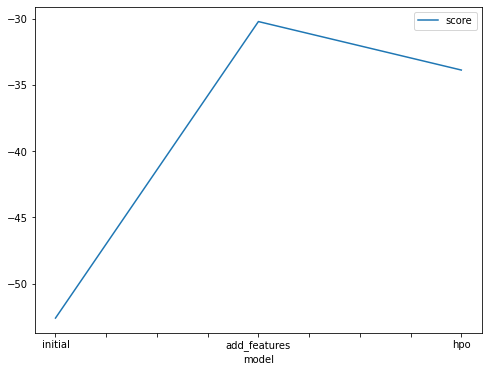

In [70]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [-52.588686, -30.214835, -33.873361]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

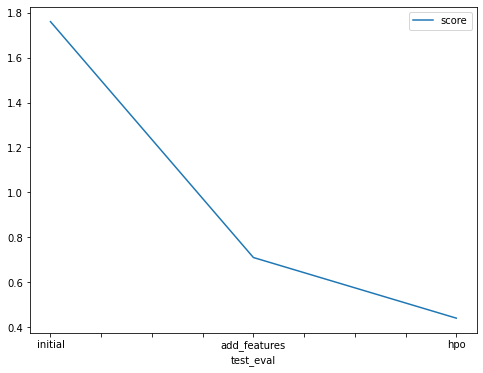

In [72]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.76, 0.71, 0.44]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [73]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "names": ["first", "second", "third"],
    "time": ["time = 600", "time = 600", "time = 600"],
    "presets": ["best_quality", "best_quality", "best_quality"],
    "score": [1.76, 0.71, 0.44]
})

,model,names,time,presets,score
0,initial,first,time = 600,best_quality,1.76
1,add_features,second,time = 600,best_quality,0.71
2,hpo,third,time = 600,best_quality,0.44
